In [1]:
%load_ext autoreload
%autoreload 2

from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np

os.chdir('../')
from src import models

In [2]:
os.getcwd()

'/home/maureen/Documents/Galvanize/Capstone1/Capstone3/Cancer_Prediction'

## Using my custom FastAI model class

data/Histology/40X/train_fastAI
data/Histology/40X/train_fastAI ['benign', 'malignant']
benign


malignant


epoch,train_loss,valid_loss,error_rate,time
0,0.771541,0.314403,0.106329,04:21
1,0.584618,0.224033,0.088608,04:03
2,0.446887,0.197616,0.078481,04:02
3,0.364069,0.187151,0.075949,04:06


data/Histology/100X/train_fastAI
data/Histology/100X/train_fastAI ['benign', 'malignant', 'models']
benign


malignant


epoch,train_loss,valid_loss,error_rate,time
0,0.991438,0.563094,0.254258,08:14
1,0.721888,0.451667,0.223844,08:35
2,0.600188,0.430579,0.212895,08:53


KeyboardInterrupt: 

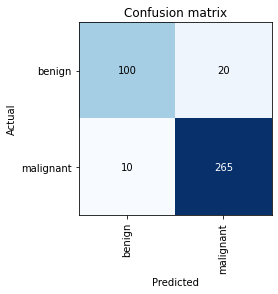

In [8]:
# Run on Histology data
mag = ['40X', '100X', '200X', '400X']
learners = []
confusions = []
predictions_all = []

def get_predictions(path, model):
    image_paths = [os.path.join(path,f) for f in os.listdir(path)]
    predictions = [model.predict_image(img) for img in image_paths]
 
    return predictions

for m in mag:
    train_path = f'data/Histology/{m}/train_fastAI'
    test_path = f'data/Histology/{m}/test/test'
    print(train_path)
    
    model = models.FastAI(train_path)
    print(model.path, model.classes)
    
    model.verify_images(500)
    model.fit(f'fastai_{m}')    
    
    # Val Metrics
    confusions.append(model.confusion_matrix())
    
    # Test predictions
    predictions_all.append(get_predictions(test_path, model))


AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [7]:
predictions

[(Category tensor(0), tensor(0), tensor([0.9956, 0.0044])),
 (Category tensor(1), tensor(1), tensor([0.0025, 0.9975])),
 (Category tensor(1), tensor(1), tensor([0.0272, 0.9728])),
 (Category tensor(1), tensor(1), tensor([0.0044, 0.9956])),
 (Category tensor(1), tensor(1), tensor([0.0102, 0.9898])),
 (Category tensor(1), tensor(1), tensor([0.0132, 0.9868])),
 (Category tensor(0), tensor(0), tensor([0.9870, 0.0130])),
 (Category tensor(1), tensor(1), tensor([0.1170, 0.8830])),
 (Category tensor(1), tensor(1), tensor([0.0013, 0.9987])),
 (Category tensor(1), tensor(1), tensor([0.0023, 0.9977])),
 (Category tensor(1), tensor(1), tensor([0.0025, 0.9975])),
 (Category tensor(0), tensor(0), tensor([0.9704, 0.0296])),
 (Category tensor(1), tensor(1), tensor([0.0029, 0.9971])),
 (Category tensor(1), tensor(1), tensor([0.0242, 0.9758])),
 (Category tensor(1), tensor(1), tensor([0.0034, 0.9966])),
 (Category tensor(1), tensor(1), tensor([0.4013, 0.5987])),
 (Category tensor(0), tensor(0), tensor(

In [40]:
path = Path('data/Histology/40X/train_fastAI')
model = models.FastAI(path)
model.path, model.classes

(PosixPath('data/Histology/100X/train_fastAI'), ['benign', 'malignant'])

In [41]:
model.verify_images(500)

benign


malignant


'done'

In [42]:
learner = model.fit('fastai-test')

epoch,train_loss,valid_loss,error_rate,time
0,0.828693,0.364510,0.141119,03:19
1,0.598147,0.300704,0.097324,03:28
2,0.467343,0.220554,0.072993,03:24
3,0.373331,0.210536,0.072993,03:24


Learner(data=ImageDataBunch;

Train: LabelList (1646 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,benign,benign,benign,benign
Path: data/Histology/100X/train_fastAI;

Valid: LabelList (411 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
benign,malignant,malignant,malignant,malignant
Path: data/Histology/100X/train_fastAI;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1):

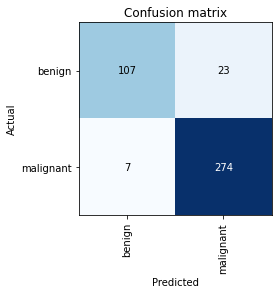

In [43]:
model.confusion_matrix()

In [47]:
model.predict_image('data/Histology/100X/test/test/SOB_M_DC-14-2980-100-006.png')

(['benign', 'malignant'],
 (Category tensor(1), tensor(1), tensor([3.9634e-04, 9.9960e-01])))

In [50]:
model.learning_rate()

AttributeError: 'Learner' object has no attribute 'lrs'

## The long way

In [5]:
path = Path('data/Histology/100X/train_fastAI')

In [6]:
# Go through folder, resize anything larger than 500 pix
for folder in ['benign', 'malignant']:
    print(folder)
    verify_images(path/folder, delete=True, max_size=500)

benign


malignant


In [7]:
# Set up validation percent
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2,
                                 ds_tfms=get_transforms(), size=224, 
                                  num_workers=4).normalize(imagenet_stats)
# Check things
print(data.classes)
data.show_batch(rows=3)

In [21]:
## Start training
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

# Fit some data
defaults.device = torch.device('cuda')
learn.fit_one_cycle(4)

In [33]:
# Save things and find learning rate
learn.save('histology_100x_v1')
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


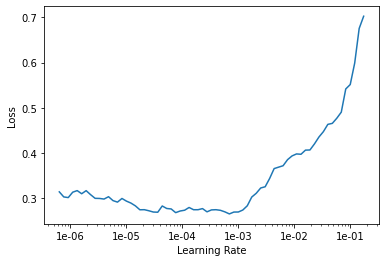

In [38]:
# Plot learning rate
learn.recorder.plot()

In [ ]:
# Confusion matrix on validation set
metric = ClassificationInterpretation.from_learner(learn)
metric.plot_confusion_matrix()

In [ ]:
# Predict single image by turning it into ItemBase and putting into predict function
path = 'data/Histology/100X/test/test/SOB_M_MC-14-13413-100-035.png'
image = open_image(path)
#data = ItemBase(path)
learn.predict(image)